In [2]:
import sys 
import os 
import pickle
import random
import numpy as np 
from astropy.io import fits
from astropy.coordinates import SkyCoord  
import astropy.units as u
import matplotlib.pylab as plt 
import pandas as pd 

plt.rc('text', usetex=True) # - Imperial cluster cannot find Latex
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [3]:
fits_image = fits.open('./data/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits')
data = fits_image[1].data
fits_image.close()

# Notes
Important columns identified in the catalogue.

## Positions on the sky
- ALPHA_J2000 (deg)
- DELTA_J2000 (deg)

## Ellipticities and Weights
- e1
- e2
- weight

## Flux
- FLUX_GAAP_u (count)
- FLUX_GAAP_g (count)
- FLUX_GAAP_r (count)
- FLUX_GAAP_i (count)
- FLUX_GAAP_Z (count)
- FLUX_GAAP_Y (count)
- FLUX_GAAP_J (count)
- FLUX_GAAP_H (count)
- FLUX_GAAP_Ks (count)

## Flux Errors
- FLUXERR_GAAP_u (count)
- FLUXERR_GAAP_g (count)
- FLUXERR_GAAP_r (count)
- FLUXERR_GAAP_i (count)
- FLUXERR_GAAP_Z (count)
- FLUXERR_GAAP_Y (count)
- FLUXERR_GAAP_J (count)
- FLUXERR_GAAP_H (count)
- FLUXERR_GAAP_Ks (count)

## Magnitude
- MAG_GAAP_u (mag)
- MAG_GAAP_g (mag)
- MAG_GAAP_r (mag)
- MAG_GAAP_i (mag)
- MAG_GAAP_Z (mag)
- MAG_GAAP_Y (mag)
- MAG_GAAP_J (mag)
- MAG_GAAP_H (mag)
- MAG_GAAP_Ks (mag)

## Magnitude Error
- MAGERR_GAAP_u (mag)
- MAGERR_GAAP_g (mag)
- MAGERR_GAAP_r (mag)
- MAGERR_GAAP_i (mag)
- MAGERR_GAAP_Z (mag)
- MAGERR_GAAP_Y (mag)
- MAGERR_GAAP_J (mag)
- MAGERR_GAAP_H (mag)
- MAGERR_GAAP_Ks (mag)

## Magnitude Limit
- MAG_LIM_u (mag)
- MAG_LIM_g (mag)
- MAG_LIM_r (mag)
- MAG_LIM_i (mag)
- MAG_LIM_Z (mag)
- MAG_LIM_Y (mag)
- MAG_LIM_J (mag)
- MAG_LIM_H (mag)
- MAG_LIM_Ks (mag)

## Flag (all of them 0)
- FLAG_GAAP_u
- FLAG_GAAP_g
- FLAG_GAAP_r
- FLAG_GAAP_i
- FLAG_GAAP_Z
- FLAG_GAAP_Y
- FLAG_GAAP_J
- FLAG_GAAP_H
- FLAG_GAAP_Ks

## BPZ
- M_0 (reference magnitude for BPZ prior)
- Z_B (9 band BPZ redshift estimate - peak of posterior)
- Z_ML (9 band BPZ maximum likelihood redshift)
- Z_B_MIN (lower bound of the 68% confidence interval of Z_B)
- Z_B_MAX (upper bound of the 68% confidence interval of Z_B)

# Plot Objects on the Sky

We have chosen the first 500 000 objects in the catalogue. Takes a long time to plot all the samples. 

In [20]:
xarr, yarr = data['ALPHA_J2000'], data['DELTA_J2000']
nobjects = 1000000
idx = random.sample(range(len(xarr)), nobjects)
eq = SkyCoord(xarr[idx], yarr[idx], unit=u.deg)
gal = eq.galactic
colors = np.random.random((nobjects, 3))

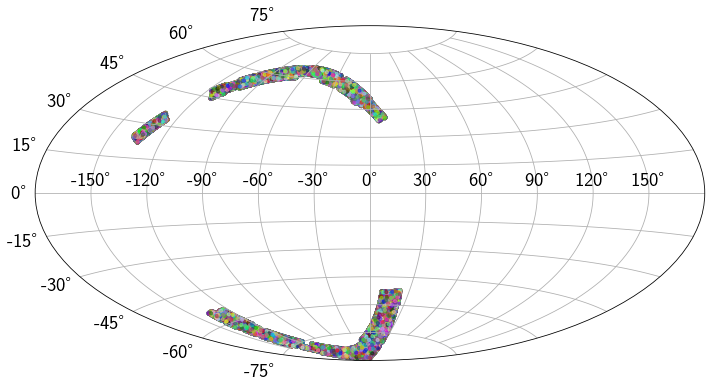

In [22]:
plt.figure(figsize = (12, 8))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=10, c=colors, alpha=0.6, edgecolors=colors, rasterized=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.savefig('plots/skymap.pdf', bbox_inches = 'tight')
plt.show()

# Choosing Specific Columns

In [41]:
band = ['u', 'g', 'r', 'i', 'Z', 'Y', 'J', 'H', 'Ks']
flux_names = [f'FLUX_GAAP_{b}' for b in band]
flux_names_err = [f'FLUXERR_GAAP_{b}' for b in band]
mag_names = [f'MAG_GAAP_{b}' for b in band]
mag_names_err =  [f'MAGERR_GAAP_{b}' for b in band]
bpz_names = ['Z_B', 'M_0', 'Z_ML', 'Z_B_MIN', 'Z_B_MAX']
meta_names = ['ALPHA_J2000', 'DELTA_J2000', 'e1', 'e2', 'weight']

nbpz = len(bpz_names)
nmeta = len(meta_names)
nband = len(band)

In [42]:
fluxes = np.asarray([data[flux_names[i]] for i in range(nband)]).T
fluxes_err = np.asarray([data[flux_names_err[i]] for i in range(nband)]).T
mag = np.asarray([data[mag_names[i]] for i in range(nband)]).T
mag_err = np.asarray([data[mag_names_err[i]] for i in range(nband)]).T
bpz = np.asarray([data[mag_names_err[i]] for i in range(nbpz)]).T
meta = np.asarray([data[meta_names[i]] for i in range(nmeta)]).T

In [69]:
df_flux = pd.DataFrame(fluxes, columns = flux_names, dtype=np.float32)
df_flux_err = pd.DataFrame(fluxes_err, columns = flux_names_err, dtype=np.float32)
df_mag = pd.DataFrame(mag, columns = mag_names, dtype=np.float16)
df_mag_err = pd.DataFrame(mag_err, columns = mag_names_err, dtype=np.float16)
df_bpz = pd.DataFrame(bpz, columns = bpz_names, dtype=np.float16)
df_meta = pd.DataFrame(meta, columns = meta_names, dtype=np.float16)

## Idea about the size of the dataframes

In [70]:
def get_size_mb(dataframe: pd.DataFrame) -> float:
    print(f'Size of dataframe in MB is {sys.getsizeof(dataframe)/1024**2:.2f}')    

In [71]:
get_size_mb(df_flux)

Size of dataframe in MB is 729.97


In [72]:
get_size_mb(df_flux_err)

Size of dataframe in MB is 729.97


In [73]:
get_size_mb(df_mag)

Size of dataframe in MB is 364.99


In [74]:
get_size_mb(df_mag_err)

Size of dataframe in MB is 364.99


In [75]:
get_size_mb(df_bpz)

Size of dataframe in MB is 202.77


In [76]:
get_size_mb(df_meta)

Size of dataframe in MB is 202.77


## Example of the tabular format

In [77]:
df_flux.head()

,FLUX_GAAP_u,FLUX_GAAP_g,FLUX_GAAP_r,FLUX_GAAP_i,FLUX_GAAP_Z,FLUX_GAAP_Y,FLUX_GAAP_J,FLUX_GAAP_H,FLUX_GAAP_Ks
0,1.056200e-11,1.392500e-10,1.615300e-10,2.616000e-10,316.019989,557.820007,221.858902,905.090027,924.590027
1,6.060100e-11,8.435300e-10,4.170800e-09,7.162000e-09,11010.000000,14520.000000,18281.925781,24005.000000,27658.000000
2,1.579000e-10,3.678500e-10,6.326800e-10,8.714600e-10,1914.500000,1557.099976,2037.095947,2146.000000,5169.600098
3,2.215500e-10,1.250500e-10,2.747600e-10,2.562200e-10,474.690002,890.419983,382.773987,2217.699951,856.369995
4,1.051100e-10,2.209900e-10,5.564200e-10,1.192700e-09,2096.135986,2520.406494,4021.867676,6219.298828,9032.557617


In [78]:
df_flux_err.head()

,FLUXERR_GAAP_u,FLUXERR_GAAP_g,FLUXERR_GAAP_r,FLUXERR_GAAP_i,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks
0,6.540000e-11,2.810000e-11,3.120000e-11,7.300000e-11,161.000000,381.000000,424.805298,1030.000000,943.000000
1,7.250000e-11,3.210000e-11,3.710000e-11,8.580000e-11,178.000000,428.000000,481.546692,1200.000000,1100.000000
2,6.910000e-11,3.020000e-11,3.450000e-11,8.000000e-11,170.000000,407.000000,455.338013,1130.000000,1030.000000
3,6.620000e-11,2.860000e-11,3.220000e-11,7.520000e-11,164.000000,390.000000,382.330353,1060.000000,971.000000
4,5.290000e-11,2.640000e-11,2.930000e-11,6.770000e-11,120.152008,280.437103,275.078003,886.384155,702.218994


In [79]:
df_mag.head()

,MAG_GAAP_u,MAG_GAAP_g,MAG_GAAP_r,MAG_GAAP_i,MAG_GAAP_Z,MAG_GAAP_Y,MAG_GAAP_J,MAG_GAAP_H,MAG_GAAP_Ks
0,99.00000,24.546875,24.421875,23.921875,23.718750,23.093750,24.109375,22.59375,22.578125
1,99.00000,22.593750,20.890625,20.328125,19.859375,19.562500,19.328125,19.03125,18.890625
2,24.40625,23.500000,22.937500,22.625000,21.750000,21.984375,21.703125,21.65625,20.703125
3,24.03125,24.671875,23.843750,23.953125,23.265625,22.593750,23.515625,21.62500,22.656250
4,24.81250,24.031250,23.062500,22.265625,21.640625,21.453125,20.968750,20.50000,20.093750


In [80]:
df_mag_err.head()

,MAGERR_GAAP_u,MAGERR_GAAP_g,MAGERR_GAAP_r,MAGERR_GAAP_i,MAGERR_GAAP_Z,MAGERR_GAAP_Y,MAGERR_GAAP_J,MAGERR_GAAP_H,MAGERR_GAAP_Ks
0,6.722656,0.219116,0.209717,0.302979,0.553223,0.741699,2.078125,1.235352,1.107422
1,1.298828,0.041321,0.009659,0.013008,0.017548,0.032013,0.028595,0.054260,0.043182
2,0.475098,0.089111,0.059204,0.099670,0.096436,0.283691,0.242676,0.571777,0.216309
3,0.324463,0.248291,0.127197,0.318604,0.375000,0.475586,1.084961,0.519043,1.231445
4,0.546387,0.129761,0.057159,0.061615,0.062225,0.120789,0.074280,0.154785,0.084412


In [81]:
df_bpz.head()

,Z_B,M_0,Z_ML,Z_B_MIN,Z_B_MAX
0,6.722656,0.219116,0.209717,0.302979,0.553223
1,1.298828,0.041321,0.009659,0.013008,0.017548
2,0.475098,0.089111,0.059204,0.099670,0.096436
3,0.324463,0.248291,0.127197,0.318604,0.375000
4,0.546387,0.129761,0.057159,0.061615,0.062225


In [82]:
df_meta.head()

,ALPHA_J2000,DELTA_J2000,e1,e2,weight
0,128.625,-1.964844,0.098511,0.471191,0.711426
1,128.625,-1.958984,0.257568,-0.295166,15.539062
2,128.625,-1.956055,-0.124817,0.164185,14.460938
3,128.625,-1.951172,0.185913,-0.180664,6.761719
4,128.625,-1.242188,-0.278320,0.182617,9.468750


## Save the files

In [83]:
def pickle_save(file: list, folder_name: str, file_name: str) -> None:
    """Stores a list in a folder.
    Args:
        list_to_store (list): The list to store.
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    """

    # create the folder if it does not exist
    os.makedirs(folder_name, exist_ok=True)

    # use compressed format to store data
    with open(folder_name + "/" + file_name + ".pkl", "wb") as f:
        pickle.dump(file, f)


def pickle_load(folder_name: str, file_name: str) -> pd.DataFrame:
    """Reads a list from a folder.
    Args:
        folder_name (str): The name of the folder.
        file_name (str): The name of the file.
    Returns:
        pd.DataFrame: a pandas dataframe
    """

    with open(folder_name + "/" + file_name + ".pkl", "rb") as f:
         file = pickle.load(f)

    return file

In [84]:
# pickle_save(df_flux, 'data/processed', 'flux')
# pickle_save(df_flux_err, 'data/processed', 'flux_err')
# pickle_save(df_mag, 'data/processed', 'mag')
# pickle_save(df_mag_err, 'data/processed', 'mag_err')
# pickle_save(df_meta, 'data/processed', 'meta')
# pickle_save(df_bpz, 'data/processed', 'bpz')

## Main Configuration File

To write main configuration file

In [88]:
from configs.configuration import get_config

In [89]:
CONFIG = get_config()

In [91]:
CONFIG.flux.names

['FLUX_GAAP_u',
 'FLUX_GAAP_g',
 'FLUX_GAAP_r',
 'FLUX_GAAP_i',
 'FLUX_GAAP_Z',
 'FLUX_GAAP_Y',
 'FLUX_GAAP_J',
 'FLUX_GAAP_H',
 'FLUX_GAAP_Ks']

In [92]:
CONFIG.flux.err_names

['FLUXERR_GAAP_u',
 'FLUXERR_GAAP_g',
 'FLUXERR_GAAP_r',
 'FLUXERR_GAAP_i',
 'FLUXERR_GAAP_Z',
 'FLUXERR_GAAP_Y',
 'FLUXERR_GAAP_J',
 'FLUXERR_GAAP_H',
 'FLUXERR_GAAP_Ks']